*Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org. Here, we will read in some point data and then plot a timeseries*
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda)

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - dateutil: for timseries generation
    - numpy

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

1) Download Data

If you have downloaded this notebook to your local drive, then you will also need to download some data. You can use this notebook to plot any CryoTEMPO-EOLIS point data that you choose. For a quick example, follow the below instructions to download a small example dataset:

    - Cryotempo-EOLIS data is downloaded using cs2eo.org
    - Paste the following url into your browser:
    https://cs2eo.org/search?searchMode=single-polygon&productA=TEMPO_SWATH_POINT&polygon=[[-21.42,65.23],[-20.98,62.95],[-13.55,62.86],[-13.74,65.37],[-21.42,65.23]]&startDate=2021-07-01&startTime=00:00&endDate=2022-05-01&endTime=00:00&trackSpacing=100&batchRequest=false
    - This will take you to a specific query of Iceland.
    - Click on the link to 'Download CryoSat-2 CryoTEMPO EOLIS Point Product data'
    - This will download a python script that you should run in a terminal - it will download 11 months of point data for this region to your current directory. This will take a couple of minutes. It requires 79MB of space on your local drive. 
    - Once the data has downloaded, you can work through the steps described in this notebook

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Imports necessary to run the rest of the code

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import glob
import datetime
from dateutil.relativedelta import *
import numpy as np
import matplotlib.dates as mdate

Function to retrieve data from a net cdf file and store as a dataframe.

In [2]:
def extract_data_from_net_cdfs(filepath):
    
    data = {}
    with nc.Dataset(filepath) as netcdf:
        for column in netcdf.variables:
            rows_from_nc = netcdf.variables[column]
            data[column] = pd.Series(rows_from_nc[:])
            
    return pd.DataFrame(data)

Function to extract the dates associated with each row in a dataframe. It will find the unique dates, and return them as datetime.datetime objects.

In [3]:
def extract_dates_from_dataframe(data):
    
    time_list = data['time']
    time_bins = data.time.unique()
    time_bins.sort()
    timestamp_list = []
    
    for i in range(len(time_bins)):
        timestamp = datetime.datetime.fromtimestamp(time_bins[i])
        timestamp_list.append(timestamp)
        
    return timestamp_list  

Function to generate a basic timeseries from a dataframe of Cryotempo-EOLIS point data. 

In [4]:
def generate_timeseries(data, dates):
    
    interval = 90.
    medians, errors = [], []
    column = 'elevation'
    
    for idx, date in enumerate(dates):
        startdate = datetime.datetime.timestamp(date-relativedelta(days=+(interval/2)))
        enddate = datetime.datetime.timestamp(date+relativedelta(days=+(interval/2)))
        df_filt = data[(data.time >= startdate) & (data.time < enddate)].reindex()

        medians.append(np.nanmedian(df_filt[column]))
        errors.append(df_filt[column].sem())

    medians = np.where(np.abs(np.array(medians)-np.nanmean(medians)) <= (3*np.nanstd(medians)), np.array(medians), np.nan)
    medians = np.where(np.array(errors) <= 3, np.array(medians), np.nan)
    
    timeseries_df = pd.DataFrame()
    timeseries_df['dates'] = dates
    timeseries_df['medians'] = medians
    timeseries_df['errors'] = errors
    
    return timeseries_df

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
2. Load downloaded data into python

If you have downloaded the notebook onto your local machine, you will need to edit the filepath below to point to the location of the downloaded data. We will then locate and store the names of each of the point data files. The point data is stored in *netcdf* files, which have the suffix .nc

In [15]:
# Fill this filepath in with the location of the downloaded point data on your local system
data_filepath = '/data/ox1/working/cryotempo_investigations/eolis_demo/point_data/'
files = sorted(glob.glob(data_filepath+'/*.nc'))

Now that the files containing the data have been located, we will load the data that they contain into python, one file at a time. The following code calls the extract_data_from_net_cdfs function, which: opens a netcdf file, reads in the data associated with each variable, and stores this data in the column of a dataframe.
After loading in the data from each individual file returned by the point product query, we will combine them into one dataframe. Finally, we will roughly mask the dataframe to remove points that are not close to the Vatnajokull glacier. To do this precisely, one would need to use a file that specifies the exact geographic location of the glacier. For simplicity here, we use a simple rectangle.

In [16]:
# Use extract_data_from_net_cdfs to populate a dataframe with the downloaded Cryotempo-EOLIS point product
list_of_dataframes_from_netcdfs = []

for i in range(len(files)):
    df = extract_data_from_net_cdfs(files[i])
    list_of_dataframes_from_netcdfs.append(df)
    
# Combine individual dataframes into 1, containing all data from this cs2eo query
full_query_results = pd.concat(list_of_dataframes_from_netcdfs)

# Crude polygon masking to extract points roughtly on Vatnajokull icecap
min_x, max_x, min_y, max_y = 1267940, 1391579, -2544293, -2421871
full_query_results = full_query_results[(full_query_results['x'] >= min_x) & (full_query_results['x'] <= max_x) & (full_query_results['y'] >= min_y) & (full_query_results['y'] <= max_y)]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
3. Use the Cryotempo-EOLIS point product to plot a timeseries for this area of Greenland

Now that the data has been loaded into the notebook, and stored in a dataframe, we can create some visuals that allow us to quickly explore the point product and its capabilities.

Firstly, we can establish the scale of the data included in 11 months of the point product. If we run the cell below, we can see that this query contains 2,620,015 data points (within our crude masking of Vatnajokull). Additionally, the variables available for analysis include a time, x and y position, elevation and an associated uncertainty value. For more information about the derivation of these variables, see ...(DOCS).... Finally, we can see that the timestamps assigned to each data point cover the range that we inputted into our original query: 7/2021 - 4/2022.

In [17]:
# Dataframe meta data that describes results of query
dates = extract_dates_from_dataframe(full_query_results)

print('Number of points in query =',len(full_query_results))
print('Variables returned by query: ',full_query_results.columns)
print('Point data from ',dates[0],' to ',dates[-1])

Number of points in query = 2620015
Variables returned by query:  Index(['time', 'x', 'y', 'elevation', 'uncertainty', 'isSwath', 'inputfileid'], dtype='object')
Point data from  2021-07-01 09:03:35  to  2022-04-25 05:44:58


Next, we will use the query dataframe that we have created to generate an elevation timeseries for the Vatnajokull glacier, covering the short time period July 2021 - April 2022. This is the approximate available coverage of the CryoTEMPO-EOLIS point product in Iceland (accurate as of 4/8/2022). If the user is looking for a more extensive temporal dataset, the Greenland and Antarctic regions have point products available dating back to July 2010. 
The generate_timeseries function called below uses the query dataframe to generate a new dataframe, containing an elevation data point at month intervals. Using this function for timeseries generation is a simplified example,  

In [18]:
# Use generate_timeseries function to calculate a 12 month timeseries for this dataset, using a 90 day overlap and some basic filtering
timeseries_df = generate_timeseries(full_query_results,dates)

Text(0.5, 1.0, 'Timeseries for Vatnajokull')

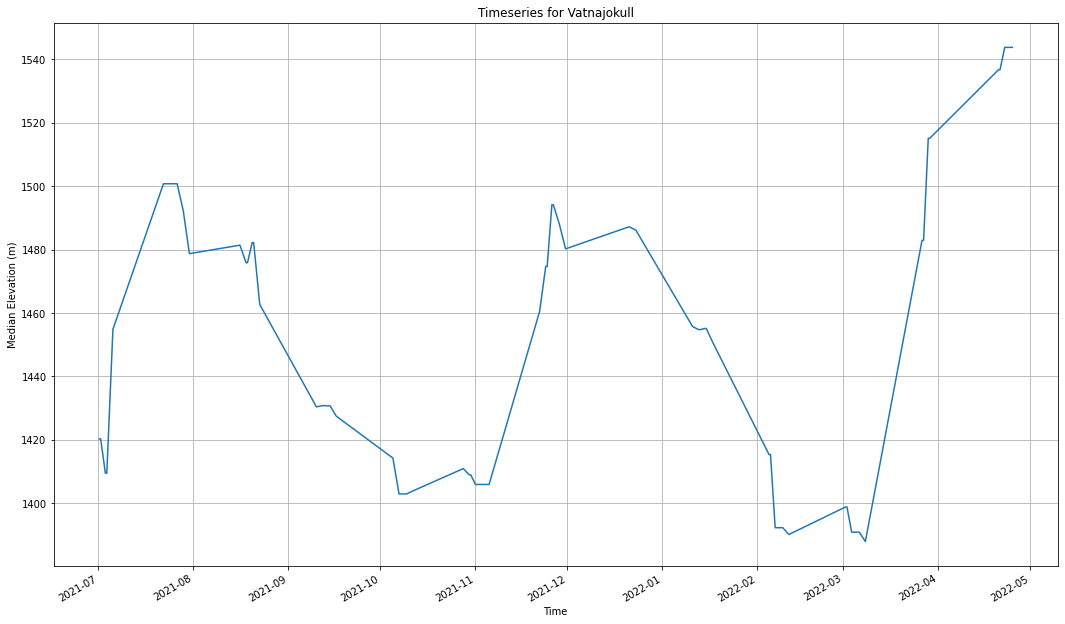

In [19]:
# Plot the timeseries dataframe
fig, axs = plt.subplots(1,1,figsize=(18,10))

axs.plot(timeseries_df['dates'],timeseries_df['medians'])
axs.set_ylabel('Median Elevation (m)')
axs.set_xlabel('Time')

axs.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs.grid(visible=True) 
axs.set_title('Timeseries for Vatnajokull')